# KoBERT 모델링

## 1. 데이터 준비

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 로드
train_df = pd.read_csv('../../data/train.csv')
general_df = pd.read_csv('../../data/train_daily.csv')

# 데이터 합치기
df = pd.concat([train_df, general_df], ignore_index=True)

# 중복 제거
print(f'중복 제거 전 데이터 크기: {len(df)}')
df.drop_duplicates(subset=['conversation'], keep='first', inplace=True, ignore_index=True)
print(f'중복 제거 후 데이터 크기: {len(df)}')

# README에 지정된 클래스 인덱스 정보 매핑
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
df['class'] = df['class'].map(class_mapping)

중복 제거 전 데이터 크기: 4850
중복 제거 후 데이터 크기: 4744


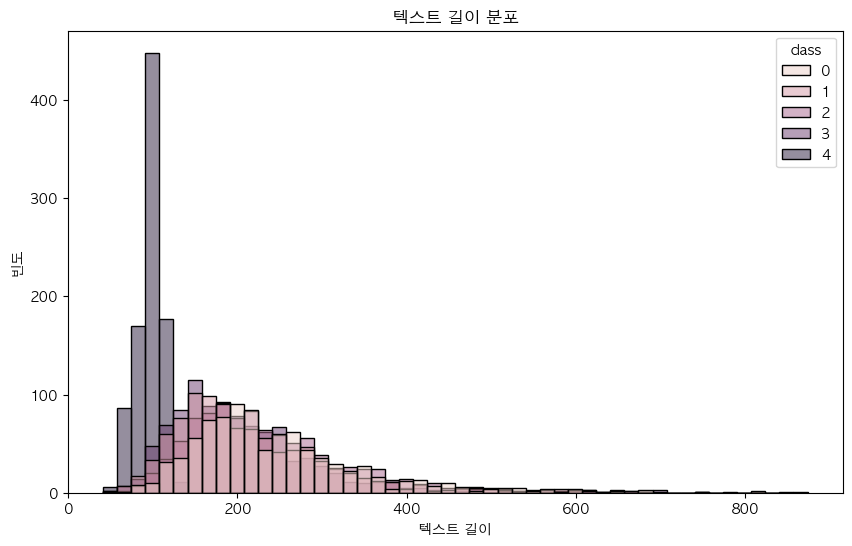


텍스트 길이 통계:
count    4744.000000
mean      202.906830
std       107.833448
min        41.000000
25%       119.000000
50%       183.000000
75%       252.000000
max       874.000000
Name: text_length, dtype: float64


In [2]:
# 텍스트 길이 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')

# 텍스트 길이 계산
df['text_length'] = df['conversation'].str.len()

# 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='class', bins=50)
plt.title('텍스트 길이 분포')
plt.xlabel('텍스트 길이')
plt.ylabel('빈도')
plt.show()

# 기본 통계량 출력
print("\n텍스트 길이 통계:")
print(df['text_length'].describe())

In [3]:
import re
from soynlp.normalizer import repeat_normalize

def preprocess_text(text):
    # 1. 반복되는 문자 정규화
    text = repeat_normalize(text, num_repeats=2)
    
    # 2. 특수문자 처리
    # 의미있는 특수문자는 보존하고 나머지는 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s\.,!?~()]', '', text)
    
    # 3. 여러 개의 공백을 하나로
    text = re.sub(r'\s+', ' ', text)
    
    # 4. 앞뒤 공백 제거
    text = text.strip()
    
    return text

# 전처리 적용
print("텍스트 전처리 적용 중...")
df['conversation_preprocessed'] = df['conversation'].apply(preprocess_text)

# 전처리 전후 비교 예시 출력
print("\n전처리 전후 비교 (처음 5개 샘플):")
for i in range(5):
    print(f"\n[예시 {i+1}]")
    print(f"전처리 전: {df['conversation'].iloc[i]}")
    print(f"전처리 후: {df['conversation_preprocessed'].iloc[i]}")

# 전처리된 텍스트 길이 분포 확인
df['preprocessed_length'] = df['conversation_preprocessed'].str.len()
print("\n전처리 후 텍스트 길이 통계:")
print(df['preprocessed_length'].describe())

# MAX_LEN 설정을 위한 분위수 확인
print("\n텍스트 길이 분위수:")
print(df['preprocessed_length'].quantile([0.5, 0.8, 0.9, 0.95, 0.99]))

텍스트 전처리 적용 중...

전처리 전후 비교 (처음 5개 샘플):

[예시 1]
전처리 전: 지금 너 스스로를 죽여달라고 애원하는 것인가?
 아닙니다. 죄송합니다.
 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.
 정말 잘못했습니다.
 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.
 죄송합니다. 정말 잘못했습니다.
 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.
 선택 못하겠습니다. 한번만 도와주세요.
 그냥 다 죽여버려야겠군. 이의 없지?
 제발 도와주세요.
전처리 후: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.

[예시 2]
전처리 전: 길동경찰서입니다.
9시 40분 마트에 폭발물을 설치할거다.
네?
똑바로 들어 한번만 더 얘기한다.
장난전화 걸지 마시죠. 
9시 40분 마트에 폭발물이 터지면 다 죽는거야. 
장난전화는 업무방해죄에 해당됩니다.
판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지.
선생님 진정하세요.
난 이야기했어. 경고했다는 말이야.
전처리 후: 길동경찰서입니다. 시 분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 시 분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.

[예시 3]
전처리 전: 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.
그만해. 니들 놀리는거 재미없어.
지영아 너가

클래스별 텍스트 길이 통계:

클래스 0:
count    892.000000
mean     243.451794
std      105.419226
min       57.000000
25%      173.000000
50%      218.000000
75%      285.000000
max      818.000000
Name: preprocessed_length, dtype: float64

클래스 1:
count    973.000000
mean     212.760534
std       98.512816
min       45.000000
25%      145.000000
50%      188.000000
75%      259.000000
max      664.000000
Name: preprocessed_length, dtype: float64

클래스 2:
count    970.000000
mean     235.214433
std      103.562395
min       41.000000
25%      166.000000
50%      214.000000
75%      280.000000
max      842.000000
Name: preprocessed_length, dtype: float64

클래스 3:
count    1011.000000
mean      210.837784
std       106.146972
min        41.000000
25%       143.000000
50%       186.000000
75%       247.000000
max       874.000000
Name: preprocessed_length, dtype: float64

클래스 4:
count    898.000000
mean      93.811804
std       14.577712
min       45.000000
25%       84.000000
50%       97.000000
75%     

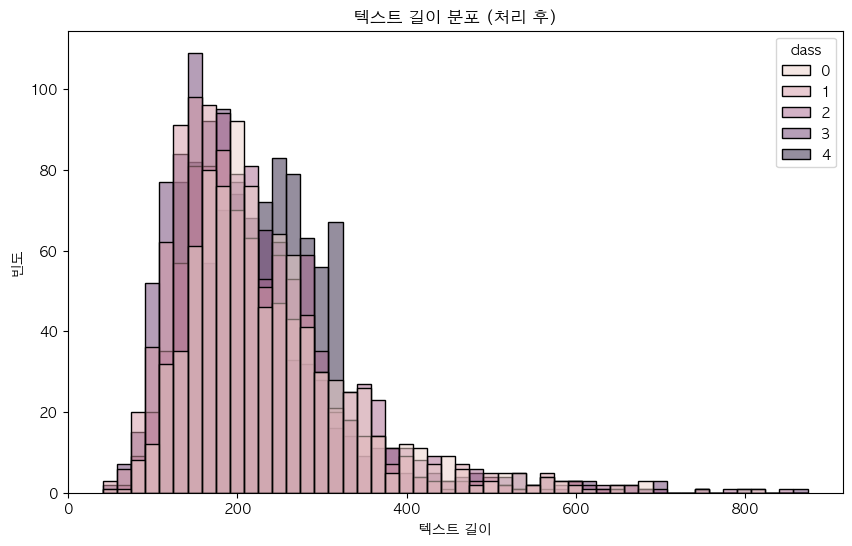

In [4]:
# 텍스트 길이 불균형 처리
print("클래스별 텍스트 길이 통계:")
for class_idx in sorted(df['class'].unique()):
    lengths = df[df['class'] == class_idx]['preprocessed_length']
    print(f"\n클래스 {class_idx}:")
    print(lengths.describe())

# 클래스별 평균과 표준편차 계산 (클래스 4 제외)
non_general_lengths = df[df['class'] != 4]['preprocessed_length']
target_mean = non_general_lengths.mean()
target_std = non_general_lengths.std()

# 목표 길이 범위 설정
min_target = int(target_mean - target_std)  # 더 넓은 범위 설정
max_target = int(target_mean + target_std)
print(f"\n목표 텍스트 길이 범위: {min_target} ~ {max_target}")

import random

def augment_short_text(text):
    """짧은 텍스트를 다양한 길이로 증강"""
    words = text.split()
    base_text = ' '.join(words)
    
    # 목표 길이를 범위 내에서 랜덤하게 선택
    target_length = random.randint(min_target, max_target)
    
    if len(base_text) >= target_length:
        return base_text
    
    # 텍스트를 반복하되, 다양한 길이로 생성
    result = []
    while len(' '.join(result)) < target_length:
        # 랜덤하게 단어 그룹 선택 (다양성을 위해)
        group_size = random.randint(1, len(words))
        selected_words = words[:group_size]
        result.extend(selected_words)
    
    # 목표 길이에 최대한 근접하도록 조정
    while len(' '.join(result)) > target_length:
        result.pop()
    
    return ' '.join(result)

# 텍스트 길이 균형 맞추기
balanced_texts = []
balanced_labels = []

for idx, row in df.iterrows():
    text = row['conversation_preprocessed']
    label = row['class']
    
    if label == 4:  # 일반 대화 처리
        augmented_text = augment_short_text(text)
        balanced_texts.append(augmented_text)
        balanced_labels.append(label)
    else:
        balanced_texts.append(text)
        balanced_labels.append(label)

# 새로운 균형 데이터셋 생성
balanced_df = pd.DataFrame({
    'conversation': balanced_texts,
    'class': balanced_labels
})

# 클래스별 텍스트 길이 통계 확인
print("\n처리 후 클래스별 텍스트 길이 통계:")
for class_idx in sorted(balanced_df['class'].unique()):
    lengths = balanced_df['conversation'].str.len()
    class_lengths = lengths[balanced_df['class'] == class_idx]
    print(f"\n클래스 {class_idx}:")
    print(class_lengths.describe())

# 텍스트 길이 분포 시각화 (처리 후)
plt.figure(figsize=(10, 6))
sns.histplot(data=balanced_df, x=balanced_df['conversation'].str.len(), hue='class', bins=50)
plt.title('텍스트 길이 분포 (처리 후)')
plt.xlabel('텍스트 길이')
plt.ylabel('빈도')
plt.show()

# 수정된 데이터로 훈련/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    balanced_df['conversation'].to_list(),
    balanced_df['class'].to_list(),
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['class'].to_list()
)

In [5]:
# 전처리된 텍스트를 사용하여 훈련/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    df['conversation_preprocessed'].to_list(),  # conversation 대신 conversation_preprocessed 사용
    df['class'].to_list(),
    test_size=0.2,
    random_state=42,
    stratify=df['class'].to_list()
)

print(f'Train data size: {len(X_train)}')
print(f'Validation data size: {len(X_val)}')

Train data size: 3795
Validation data size: 949


## 2. KoBERT 모델 및 데이터셋 준비

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer
import numpy as np
import os

# 캐시 디렉토리 설정
current_dir = os.path.dirname(os.path.abspath('__file__'))
cache_dir = os.path.join(current_dir, 'cache')
os.makedirs(cache_dir, exist_ok=True)
print(f"Cache directory: {cache_dir}")

# KoBERT 토크나이저와 모델 불러오기
try:
    print("토크나이저 로딩 시도...")
    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kobert-base-v1',
        cache_dir=cache_dir,
        use_fast=False  # Fast tokenizer 비활성화
    )
    print("토크나이저 로딩 완료")
    
    print("모델 로딩 시도...")
    bert_model = AutoModel.from_pretrained(
        'skt/kobert-base-v1',
        cache_dir=cache_dir
    )
    print("모델 로딩 완료")
    
except Exception as e:
    print(f"모델 로드 중 오류 발생: {str(e)}")
    print("대체 방법으로 다운로드 시도...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(
            'skt/kobert-base-v1',
            use_fast=False
        )
        bert_model = AutoModel.from_pretrained('skt/kobert-base-v1')
        print("모델 다운로드 성공")
    except Exception as e2:
        print(f"모든 다운로드 시도 실패: {str(e2)}")
        raise e2

print("KoBERT 모델 및 토크나이저 로드 과정 완료!")

Cache directory: /Users/bychoi/develop/dlthon/DKTC/02. 모델링/KoBERT/cache
토크나이저 로딩 시도...
토크나이저 로딩 완료
모델 로딩 시도...
모델 로딩 완료
KoBERT 모델 및 토크나이저 로드 과정 완료!


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# PyTorch Dataset 클래스 정의
class BERTDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

# 파라미터 설정
MAX_LEN = 256  # 텍스트 길이 분포를 고려하여 조정 (95% 수준)
BATCH_SIZE = 32  # 배치 사이즈는 GPU 메모리에 따라 조절

# 데이터셋 및 데이터로더 생성
train_dataset = BERTDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = BERTDataset(X_val, y_val, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('KoBERT 데이터셋 및 데이터로더 준비 완료')

KoBERT 데이터셋 및 데이터로더 준비 완료


## 3. 모델 및 학습 함수 정의

In [8]:
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# 개선된 KoBERT 분류 모델 정의
class KoBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=5):
        super(KoBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout1 = nn.Dropout(0.3)  # Dropout 비율 증가
        self.dropout2 = nn.Dropout(0.2)
        hidden_size = self.bert.config.hidden_size
        
        # 추가 레이어
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size // 2)
        self.classifier = nn.Linear(hidden_size // 2, num_classes)
        
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input_ids, attention_mask):
        # BERT 출력
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]  # (batch_size, sequence_length, hidden_size)
        
        # Mean pooling
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size())
        sequence_output = sequence_output * attention_mask_expanded
        pooled_output = sequence_output.sum(1) / attention_mask_expanded.sum(1)
        
        # 추가 레이어를 통한 처리
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout1(pooled_output)
        
        pooled_output = self.linear1(pooled_output)
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout2(pooled_output)
        
        pooled_output = self.linear2(pooled_output)
        pooled_output = self.relu(pooled_output)
        
        logits = self.classifier(pooled_output)
        return logits

# 학습 함수
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader, desc="Training", ncols=100):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        # Gradient Clipping 추가
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    return correct_predictions.float() / n_examples, np.mean(losses)

# 평가 함수
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Validation", ncols=100):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_predictions.float() / n_examples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, np.mean(losses), f1

print("개선된 KoBERT 모델 및 학습/평가 함수 정의 완료!")

개선된 KoBERT 모델 및 학습/평가 함수 정의 완료!


## 4. 모델 학습 실행

In [ ]:
from collections import defaultdict

# 학습 파라미터 설정
EPOCHS = 5  # 에폭 수 증가
BATCH_SIZE = 32  # 배치 사이즈 증가
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model = KoBERTClassifier(bert_model)
model = model.to(device)

# AdamW 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# 총 학습 스텝 수 계산
total_steps = len(train_dataloader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Learning rate scheduler 설정
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# Early Stopping 파라미터
patience = 3
best_f1_score = 0
early_stopping_counter = 0

history = defaultdict(list)

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    
    print(f'Train loss {train_loss:.4f} | accuracy {train_acc:.4f}')
    
    val_acc, val_loss, val_f1 = eval_model(
        model,
        validation_dataloader,
        loss_fn,
        device,
        len(val_dataset)
    )
    
    print(f'Val loss {val_loss:.4f} | accuracy {val_acc:.4f} | F1 score {val_f1:.4f}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    # F1 점수가 개선되었을 때 모델 저장
    if val_f1 > best_f1_score:
        torch.save(model.state_dict(), 'kobert_best_model_state.bin')
        best_f1_score = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    # Early Stopping 체크
    if early_stopping_counter >= patience:
        print(f"\nEarly stopping triggered after epoch {epoch + 1}")
        break

print("\n--- 학습 종료 ---")
print(f"Best validation F1 score: {best_f1_score:.4f}")

Using device: mps
--- Epoch 1/5 ---


Training:  26%|█████████████▌                                      | 31/119 [15:51<45:01, 30.70s/it]
